In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

%config InlineBackend.figure_format='retina'

!apt -qq -y install fonts-nanum

import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
plt.rc('font', family='NanumBarunGothic')

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


/tmp/ipykernel_1047/1345014585.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [2]:
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import gutenberg
from tqdm import tqdm, tqdm_pandas
from collections import Counter
from konlpy.tag import Mecab
from emoji import core
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import time
import os
import re

nltk.download('punkt')

mecab=Mecab()

[nltk_data] Downloading package punkt to /home/ssh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
df_com = pd.read_csv('./data/cafe_comment.csv')
df_main = pd.read_csv('./data/cafe_main.csv')
df_com.drop(['text_number'], axis=1, inplace=True)
df_com['etc'] = '댓글'
df_main.drop(['date','click','text_number'], axis=1, inplace=True)
df_main['etc'] = '본문'
df_com.rename(columns={'comment' : 'text'}, inplace=True)
df = pd.concat([df_com,df_main])
df.sort_values('title')
df.reset_index(drop=True, inplace=True)
df.drop_duplicates(['text'])
df

,text,nickname,title,board_name,topic,cafe_name,cafe_id,yyyy,mm,etc
0,추천드리고싶진 않지만.. 시부모님이 티칭이나 코칭이 어려우시면 패드(스마트학습)으로...,몽몽,유치원이나 얼집 보내시는 워킹맘분들 어떻게 하실건가요??,고민상담/속풀이,초 밀크티,kyungmammo,2,2020,11,댓글
1,스마트 학습 이라는 것도 있군요!!! 감사합니다.,왕구이,유치원이나 얼집 보내시는 워킹맘분들 어떻게 하실건가요??,고민상담/속풀이,초 밀크티,kyungmammo,2,2020,11,댓글
2,저는 도움청할때 없어서 그냥 보내고..학습지도 하고 다른 문제집을 사서 주말에 하고...,청말띠딸둥이맘82,유치원이나 얼집 보내시는 워킹맘분들 어떻게 하실건가요??,고민상담/속풀이,초 밀크티,kyungmammo,2,2020,11,댓글
3,사실 시어머님이 봐주시는것만으로도 정말 감사한건데 사람 욕심은 끝이 없나봐요 ㅠㅠ ...,왕구이,유치원이나 얼집 보내시는 워킹맘분들 어떻게 하실건가요??,고민상담/속풀이,초 밀크티,kyungmammo,2,2020,11,댓글
4,저도 도움청할곳이 없어 두 아이 유치원 쭉 보내고있어요\n내년에 학교들어가는 큰아이...,율이란사랑해,유치원이나 얼집 보내시는 워킹맘분들 어떻게 하실건가요??,고민상담/속풀이,초 밀크티,kyungmammo,2,2020,11,댓글
...,...,...,...,...,...,...,...,...,...,...
134889,초1아이 원래 이렇게 힘든건가요? 아이 적응하는것도 예민해가지고 신경이 더 쓰이는것...,조이풀df,아이가 학교가 재미 없대요,초등맘 톡톡(talk),초등 밀크티,gangmok,2,2022,9,본문
134890,초등 5학년인 아이가 수학을 너무 어려워해요..\n분수랑 소수가 많이 헷갈리는듯해요...,잠돼지s,초 5수학...,초등맘 톡톡(talk),초등 밀크티,gangmok,2,2022,9,본문
134891,아이가 점점 수학과 영어를 어려워 하더라고요\n영어 수학을 따로 학원을 보내야 할지...,그시절속,공부 방법이 어렵네요,초등맘 톡톡(talk),초등 밀크티,gangmok,2,2022,9,본문
134892,천재교육 밀크T 체험 진행 예정이신 맘님들!! 이랜드몰에서 신청하세요!\n체험이벤트...,오규오규맘,밀크T초등 무료체험 x 이랜드몰 제휴이벤트 해요,광고◈홍보 합니다,초등 밀크티,gangmok,2,2022,9,본문


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134894 entries, 0 to 134893
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   text        134579 non-null  object
 1   nickname    134894 non-null  object
 2   title       134894 non-null  object
 3   board_name  134894 non-null  object
 4   topic       134894 non-null  object
 5   cafe_name   134894 non-null  object
 6   cafe_id     134894 non-null  int64 
 7   yyyy        134894 non-null  int64 
 8   mm          134894 non-null  int64 
 9   etc         134894 non-null  object
dtypes: int64(3), object(7)
memory usage: 10.3+ MB


In [5]:
df.fillna('_',inplace=True)

In [6]:
df.isnull().sum()

text          0
nickname      0
title         0
board_name    0
topic         0
cafe_name     0
cafe_id       0
yyyy          0
mm            0
etc           0
dtype: int64

In [7]:
# 태그 제거
def del_tag_check(text):
    text = re.sub('http:', '', text)
    text = re.sub('comhttpsm.', '', text)
    text = re.sub(r'(\d{2,4})-(\d{3,4})-?(\d{0,4})?', '', text) # 전화번호 제거
    text = re.sub('blog.', '', text)
    text = re.sub('naver.', '', text)
    text = re.sub('co. kr', '', text)

    return text

df['text'] = df['text'].apply(lambda x : del_tag_check(x))
df['title'] = df['title'].apply(lambda x : del_tag_check(x))

In [8]:
# 문자 통일

# 영어 소문자화
df['text'] = df['text'].apply(lambda x: x.lower())

# 같은 의미를 담은 문자
def combine_check(contents):

    # 밀크티
    contents = re.sub('ㅁㅋ', '밀크', contents)
    contents = re.sub('밀ㅋ', '밀크', contents)
    contents = re.sub('ㅁ크', '밀크', contents)
    
    contents = re.sub('밀크t', '밀크티', contents) #영어를 모두 소문자화 했으므로 대문자T는 진행 X
    contents = re.sub('milkt', '밀크티', contents)
    contents = re.sub('milk티', '밀크티', contents)

    contents = re.sub('밀크[*]', '밀크티', contents)
    contents = re.sub('밀[*]티', '밀크티', contents)
    contents = re.sub('[*]크티', '밀크티', contents)
    contents = re.sub('밀[*][*]', '밀크티', contents)
    contents = re.sub('[*][*]티', '밀크티', contents)
    contents = re.sub('[*]크[*]', '밀크티', contents)

    contents = re.sub('밀크o','밀크티',contents)
    contents = re.sub('밀o티','밀크티',contents)
    contents = re.sub('o크티','밀크티',contents)
    contents = re.sub('밀oo','밀크티',contents)
    contents = re.sub('oo티','밀크티',contents)
    contents = re.sub('o크o','밀크티',contents)

    contents = re.sub('밀크0','밀크티',contents)
    contents = re.sub('밀0티','밀크티',contents)
    contents = re.sub('0크티','밀크티',contents)
    contents = re.sub('밀00','밀크티',contents)
    contents = re.sub('00티','밀크티',contents)
    contents = re.sub('0크0','밀크티',contents)

    contents = re.sub('ㅁㅋㅌ', '밀크티', contents)
    contents = re.sub('ㅁ크ㅌ', '밀크티', contents)
    contents = re.sub('밀크ㅌ', '밀크티', contents)
    contents = re.sub('밀ㅋ티', '밀크티', contents)
    
    contents = re.sub('밀크@', '밀크티', contents)
    contents = re.sub('밀@티', '밀크티', contents)
    contents = re.sub('@크티', '밀크티', contents)
    contents = re.sub('밀@@', '밀크티', contents)
    contents = re.sub('@크@', '밀크티', contents)
    contents = re.sub('@@티', '밀크티', contents)
    # contents = re.sub('밀', '밀크티', contents)
    # contents = re.sub('크', '밀크티', contents)
    # contents = re.sub('티', '밀크티', contents)

    # 홈런
    contents = re.sub('홈@', '홈런', contents)
    contents = re.sub('@런', '홈런', contents)
    # contents = re.sub('홈', '홈런', contents)
    # contents = re.sub('런', '홈런', contents)

    contents = re.sub('홈[*]', '홈런', contents)
    contents = re.sub('[*]런', '홈런', contents)

    contents = re.sub('홈o', '홈런', contents)
    contents = re.sub('o런', '홈런', contents)

    contents = re.sub('홈0', '홈런', contents)
    contents = re.sub('0런', '홈런', contents)

    contents = re.sub('ㅎㄹ', '홈런', contents)
    contents = re.sub('ㅎ런', '홈런', contents)
    contents = re.sub('홈ㄹ', '홈런', contents)

    contents = re.sub('아이스크림 홈런', '홈런', contents)
    contents = re.sub('아이스크림 에듀 홈런', '홈런', contents)

    contents = re.sub('ㅇㅇㅅㅋㄹ 홈런', '홈런', contents)
    contents = re.sub('ㅇㅇㅅㅋㄹ ㅇㄷ 홈런', '홈런', contents)    # +....


    # 윙크
    contents = re.sub('윙@', '윙크', contents)
    contents = re.sub('@크', '윙크', contents)

    contents = re.sub('윙[*]', '윙크', contents)
    contents = re.sub('[*]크', '윙크', contents)

    contents = re.sub('윙o', '윙크', contents)
    contents = re.sub('o크', '윙크', contents)

    contents = re.sub('윙0', '윙크', contents)
    contents = re.sub('0크', '윙크', contents)

    contents = re.sub('ㅇㅋ', '윙크', contents)
    contents = re.sub('ㅇ크', '윙크', contents)
    contents = re.sub('윙ㅋ', '윙크', contents)


    # 웅진 스마트올



    # 엘리하이



    # 명사
    # contents = re.sub('할미','할머니', contents)
    # contents = re.sub('티비','텔레비전', contents)

    contents = re.sub('애','아이', contents)
    contents = re.sub('','', contents)
    contents = re.sub('','', contents)
    contents = re.sub('','', contents)

    return contents

df['text'] = df['text'].apply(lambda x : combine_check(x))
df['title'] = df['title'].apply(lambda x : combine_check(x))

In [9]:
# 특수문자 제거

# display(df.text[0])

# 특수 기호 제거
df.text = df.text.apply(lambda x : re.sub('[-=+,#/\?:^$@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》\n★▲;|]',' ', x))
df.title = df.title.apply(lambda x : re.sub('[-=+,#/\?:^$@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》\n★▲;|]',' ', x))

# '\E' 모양 제거
df.text = df.text.apply(lambda x : re.sub('[\a-zA-Z]. ',' ',x))
df.title = df.title.apply(lambda x : re.sub('[\a-zA-Z]. ',' ',x))

# 이모티콘 제거
# df.text = df.text.apply(lambda x : core.replace_emoji(x, replace=''))

# # 자음만 적힌 경우 제거
# df.text = df.text.apply(lambda x : re.sub('[ㄱ-ㅎ]+', '', x))

# display(df.head())
# display(df.text[0])

In [10]:
# 자/모음만 남은 경우 제거
df.text = df.text.apply(lambda x : re.sub('[ㄱ-ㅎ]+', '', x))
df.text = df.text.apply(lambda x : re.sub('[ㅏ-ㅣ]+', '', x))

df.title = df.title.apply(lambda x : re.sub('[ㄱ-ㅎ]+', '', x))
df.title = df.title.apply(lambda x : re.sub('[ㅏ-ㅣ]+', '', x))

In [11]:
# # stop_words.txt 관리

# stop_words = sorted(stop_words)
# f = open("./stop_words.txt", 'w')
# for i in stop_words:
#     i = i + '\n'
#     f.write(i)
# f.close
with open('./stop_words.txt', encoding='utf-8') as f:
    stop_words = f.readlines()
stop_words = [line.rstrip('\n') for line in stop_words]

In [12]:
company_list = ['밀크티', '홈런', '윙크']

In [13]:
# 키워드 존재 여부
for key in company_list:
    test_list = []

    for i in range(len(df)):
        if key in df['text'][i] or key in df['title'][i]:
            test_list.append(True)

        else:
            test_list.append(False)

    df[key] = test_list

# df

# sentiment

In [14]:
# 긍/부정문 사전 필요

posi_path = "./data/positive_words.txt"
nega_path = "./data/negative_words.txt"

with open(posi_path, encoding='utf-8') as f:
    positive_words = f.readlines()

with open(nega_path, encoding='utf-8') as f:
    negative_words = f.readlines()

positive_words = [line.rstrip('\n') for line in positive_words]
negative_words = [line.rstrip('\n') for line in negative_words]

In [15]:
# 사전에서 불필요한 단어 없애기 (사전 자체를 미리 수정하면 이 코드 없어도 될듯...)

try:
    pasitive_words = pasitive_words.remove([''])
except:
    pass

try:
    negative_words = negative_words.remove(['저는', '수'])
except:
    pass

In [16]:
df_sentiment = pd.DataFrame()

for company in company_list:
    df_piece = df[df[company] == True]
    remove = list(df_piece.columns)
    remove.remove('text')
    remove.remove('title')
    df_piece.drop(remove, axis=1, inplace=True)
    df_piece['company'] = company

    df_sentiment = pd.concat([df_sentiment, df_piece], axis=0)

df_sentiment.reset_index(drop=True, inplace=True)
df_sentiment.head()

/tmp/ipykernel_1047/3929001120.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_piece.drop(remove, axis=1, inplace=True)
/tmp/ipykernel_1047/3929001120.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_piece['company'] = company
/tmp/ipykernel_1047/3929001120.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_piece.drop(remove, axis=1, inplace=True)
/tmp/ipykernel_

,text,title,company
0,왕구이전 윙크시작했고 그외에 웅진 씽크빅 홈런 밀크티 등등 많이 있더라구요 이런...,유치원이나 얼집 보내시는 워킹맘분들 어떻게 하실건가요,밀크티
1,왕구이제발그랬음 좋겠어요 밀크티 이것도괜찮아보여요 전웅진약정땜에,유치원이나 얼집 보내시는 워킹맘분들 어떻게 하실건가요,밀크티
2,깔깔이랑쭌저두 그래서 씽크빅 빨간펜 구몬 눈높이 재능 장원 한번씩 지나갔네요 지금은...,씽크빅 수업중단 궁금해요..,밀크티
3,미추홀 맘아이가 관심도 없고 선생님도 무섭다하고 ..저흰 그냥 당분간 쉬어볼려구 ...,씽크빅 수업중단 궁금해요..,밀크티
4,전 밀크티가 훨씬 낫던데요 설명해주시는분이 잘 다룰줄 모르는것 같긴 했지만 영어도...,밀크티.와이즈캠프..체험할수록고민이요..,밀크티


In [17]:
df_sentiment['company'].value_counts()

company
밀크티    37661
홈런     17950
윙크      8002
Name: count, dtype: int64

In [18]:
len(df_sentiment)

63613

In [19]:
firm = df_sentiment.get('company')
text = df_sentiment.get('text')

company = {firm[0]:text[0]}
for i in tqdm(range(len(firm))):
    if company.get(firm[i]) != None:
        company[firm[i]] = company.get(firm[i]) + "\n" + text[i]
    else:
        company[firm[i]] = text[i]

# company.get('밀크티')[:100]
# company.keys()

100%|██████████| 63613/63613 [00:28<00:00, 2215.11it/s] 


In [20]:
# 이걸 Mecab morphs로 하면 너무 잘게 쪼개서 분석이 힘듬...
tokens=[]
for f, t in company.items():
    token=word_tokenize(t)
    tokens.append([f,token])

In [21]:
# tokenize를 mecab으로 한다면...!?
test_sec = '나는 배가 고프다'
print(word_tokenize(test_sec))
print(mecab.morphs(test_sec))

print(type(word_tokenize(test_sec)))
print(type(mecab.morphs(test_sec)))
# token을 mecab을 이용하여 쪼개면... 아마 token in dict 가 아닌 anu(dict in token) 식으로 진행되어야 할 듯...

['나는', '배가', '고프다']
['나', '는', '배', '가', '고프', '다']
<class 'list'>
<class 'list'>


In [22]:
sentiment_firm=[]
posi_firm=[]
nega_firm=[]
sentiment_dic = {}
round_ = 4 # 소수점 표현 범위
posi_dic = {}
nega_dic = {}

check_list = []

import time

start = time.time()

for token in tokens:
    posi_words = []
    nega_words = []
    firm=token[0]
    sentiment=0
    count=0

    posi = 0
    nega = 0
    
    for t in tqdm(token[1]):
        if t in positive_words:
        # if any(word in t for word in positive_words):
            posi_words.append(t)
            sentiment+=1
            posi += 1
            count+=1
        elif t in negative_words:
        # elif any(word in t for word in negative_words):
            nega_words.append(t)
            sentiment -=1
            nega += 1
            count+=1
    
    sentiment_firm.append([firm,round(sentiment/count,round_)])
    posi_firm.append([firm,round(posi/count,round_)])
    nega_firm.append([firm,round(nega/count,round_)])
    sentiment_words = posi_words + nega_words
    sentiment_dic[firm] = sentiment_words
    posi_dic[firm] = posi_words
    nega_dic[firm] = nega_words
    print(f'{firm} 데이터 수 : ', len(token[1]))
    # print(f'{firm} 데이터 수 : ', len(company[firm]))
    print(f'{firm} sentiment filtering 횟수 : ', count)

end = time.time()

print()
print('긍정점수 : ', posi_firm)
print()
print('부정점수 : ', nega_firm)
print()
print('종합점수 : ', sentiment_firm)
print()
# print('데이터 수 : ', len(sentiment_words))
print('걸린 시간 : ', round(end - start, round_), '초')

100%|██████████| 799518/799518 [01:02<00:00, 12706.23it/s]


밀크티 데이터 수 :  799518
밀크티 sentiment filtering 횟수 :  17220


100%|██████████| 390368/390368 [00:30<00:00, 12891.39it/s]


홈런 데이터 수 :  390368
홈런 sentiment filtering 횟수 :  8071


100%|██████████| 178490/178490 [00:13<00:00, 12988.70it/s]

윙크 데이터 수 :  178490
윙크 sentiment filtering 횟수 :  4812

긍정점수 :  [['밀크티', 0.628], ['홈런', 0.6209], ['윙크', 0.6212]]

부정점수 :  [['밀크티', 0.372], ['홈런', 0.3791], ['윙크', 0.3788]]

종합점수 :  [['밀크티', 0.256], ['홈런', 0.2417], ['윙크', 0.2423]]

걸린 시간 :  106.9531 초


In [23]:
for i in sentiment_words:
    if len(i) <= 1:
        sentiment_words.remove(i)

Counter(sentiment_words).most_common(100)

[('저는', 1263),
 ('꾸준히', 511),
 ('재미있게', 241),
 ('좋고', 158),
 ('좋아서', 113),
 ('좋은', 92),
 ('쉽게', 89),
 ('좋을', 84),
 ('없어서', 83),
 ('좋아하고', 79),
 ('혜택', 75),
 ('좋아하는', 72),
 ('잘되어', 68),
 ('도움', 68),
 ('열심히', 61),
 ('함께', 59),
 ('좋다고', 56),
 ('혜택이', 54),
 ('할인', 49),
 ('충분히', 48),
 ('자연스럽게', 47),
 ('흥미', 44),
 ('괜찮고', 42),
 ('편하게', 38),
 ('만족', 34),
 ('제대로', 33),
 ('좋아', 32),
 ('부족한', 32),
 ('흥미가', 31),
 ('좋다', 29),
 ('이벤트', 29),
 ('중요한', 27),
 ('즐겁게', 25),
 ('모르는', 25),
 ('스트레스', 25),
 ('재미', 24),
 ('꾸준하게', 23),
 ('편하고', 22),
 ('어려운', 19),
 ('못하고', 18),
 ('싫다고', 18),
 ('걱정이', 17),
 ('가능하다', 16),
 ('유명한', 16),
 ('잘하는', 15),
 ('새로운', 12),
 ('장점', 12),
 ('거부감', 12),
 ('억지로', 11),
 ('많음', 10),
 ('걱정', 10),
 ('포기하고', 10),
 ('끊고', 10),
 ('잘되고', 9),
 ('수월하게', 9),
 ('좋게', 9),
 ('싫어서', 9),
 ('일부러', 9),
 ('재미있는', 8),
 ('신중히', 8),
 ('재밌는', 8),
 ('이해하고', 8),
 ('없다', 8),
 ('부담', 8),
 ('선호하는', 7),
 ('알차고', 7),
 ('무료로', 7),
 ('재능', 7),
 ('꼼꼼하게', 7),
 ('소중한', 7),
 ('혜택을', 7),
 ('혜택이나', 7),
 ('어려워서', 7)

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

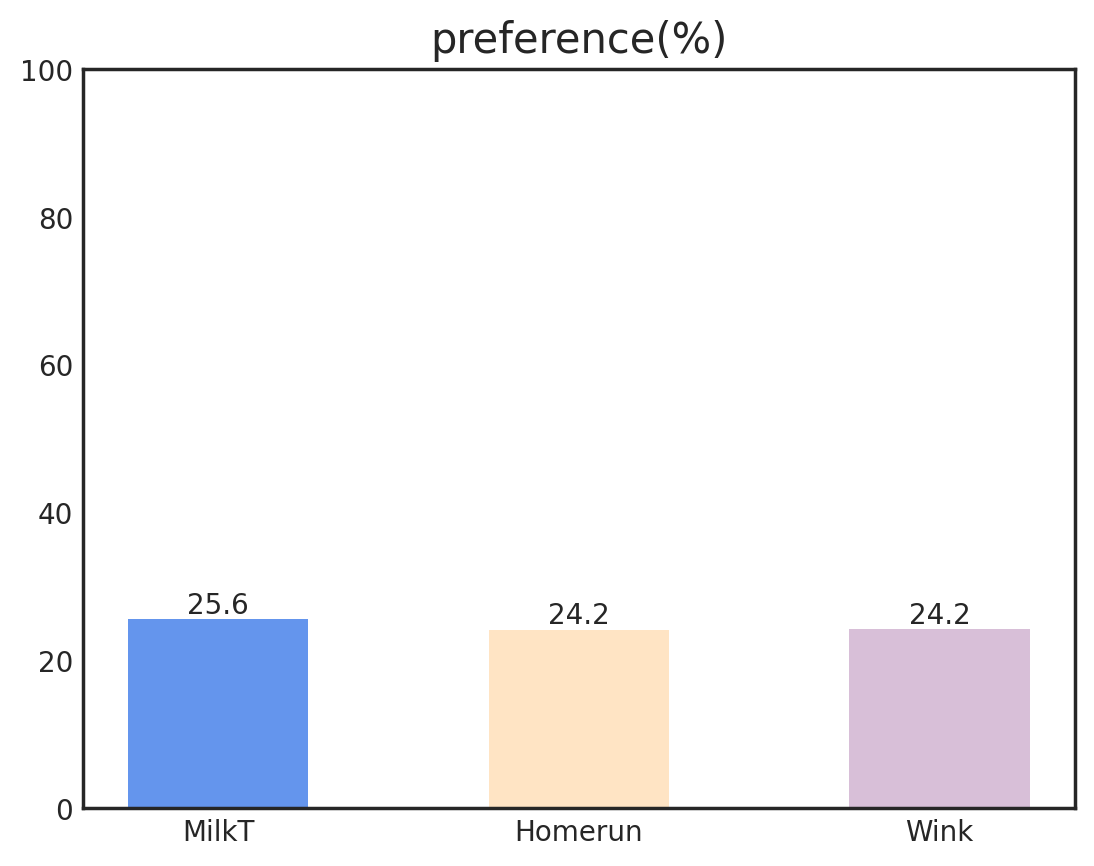

In [24]:
a=[]
for firm in sentiment_firm:
    a.append(firm[1]*100)
X=np.arange(len(a))

plt.title("preference(%)",fontsize=15)
# plt.xticks()
plt.ylim(0, 100)
plt.xticks([0, 1, 2], labels=['MilkT','Homerun','Wink'])
# plt.xlabel('..')
bar = plt.bar(X,a, color= ['cornflowerblue','bisque','thistle'], alpha = 1.0, width=0.5)

for persent in bar:
    height = persent.get_height()
    plt.text(persent.get_x() + persent.get_width()/2.0, height, '%.1f' % height, ha='center', va='bottom', size = 10)

plt.show()

---

# Filtering

- 대주제 : company
    - 밀크티
    - 윙크
    - 엘리하이
    - 와이즈캠프
    - 아이스크림 에듀

- 중주제 : 지역별, 카페별, 기간별
    - 지역별, 카페별
        - 지역 카페
            - 동탄맘
            - 인천맘
            - ...
        - 지역 카페 X
            - 초등맘
            - 레몬테라스

- 소주제 : Part
    - 파트 : 
        - 가격, 기기품질, 컨텐츠, 평가, 아이, 학부모
    
    - 과목 : 
        - 영어, 수학, 과학

    - 학년 : 
        - 초1,초2,초저~초고,중학...
            - 크롤링 검색에서 범위가 지정될 수 있음.



- → 검색 란을 만들어서 해당 키워드에 대한 인식조사...

In [25]:
# keyword사전 만들기...

test_nouns = []

for i in tqdm(df['text']):
    for j in mecab.nouns(i):
        if j not in stop_words:
            test_nouns.append(j)

Counter(test_nouns).most_common(1000)

100%|██████████| 134894/134894 [00:16<00:00, 7967.34it/s] 


[('체험', 30566),
 ('학습', 28962),
 ('밀크티', 27000),
 ('학년', 25896),
 ('영어', 22372),
 ('학원', 19280),
 ('공부', 18810),
 ('수학', 18012),
 ('수', 16834),
 ('수업', 16169),
 ('패드', 15349),
 ('문제집', 14905),
 ('초등', 12768),
 ('엘리', 11656),
 ('홈런', 11555),
 ('와이즈', 11017),
 ('생각', 10776),
 ('시간', 10123),
 ('집', 9892),
 ('선생', 9744),
 ('추천', 9433),
 ('무료', 9292),
 ('학교', 9036),
 ('시작', 8872),
 ('정도', 8810),
 ('신청', 8729),
 ('엄마', 8646),
 ('학습지', 8462),
 ('문제', 8400),
 ('분', 8157),
 ('하이', 8152),
 ('고민', 7834),
 ('윙크', 7666),
 ('과목', 7426),
 ('캠', 7370),
 ('캠프', 7110),
 ('만족', 6916),
 ('책', 6525),
 ('혜택', 6425),
 ('화상', 6328),
 ('가능', 6187),
 ('교과', 5789),
 ('도움', 5496),
 ('강의', 5469),
 ('스마트', 5440),
 ('연산', 5420),
 ('과학', 5223),
 ('필요', 5076),
 ('선택', 4867),
 ('관리', 4771),
 ('결정', 4760),
 ('교재', 4692),
 ('추천인', 4670),
 ('한글', 4549),
 ('국어', 4539),
 ('초', 4452),
 ('컨텐츠', 4358),
 ('인강', 4268),
 ('부탁', 4157),
 ('자기', 4115),
 ('약정', 3960),
 ('웅진', 3957),
 ('활용', 3957),
 ('습관', 3933),
 ('하루', 3859),
 ('살',

## part별 주제

1. 가격
    - 타 패드학습 혹은 사교육(학원,학습지 등)과 비교할 때 평가
    - 약정 가격에 대한 평가

1. 기기 품질
    - 기기 자체에 대한 평가

1. 컨텐츠
    - 해당 학습 플랫폼의 컨텐츠에 대한 평가
    
1. 평가(시험)
    - 해당 학습 플랫폼의 평가 방식에 대한 평가

1. 아이
    - 아이의 만족도 및 학업성취에 대한 평가

1. 학부모
    - 학부모의 만족도 평가

In [26]:
가격 = '가격'
key_price = ['비용','가격','교육비','약정','돈','할인','계약','영사','금액','구매','값','위약금','해지','구입','영업','렌트',]

### 가격

가격에 대한 긍/부정 여부 확인

In [27]:
firm = df_sentiment.get('company')
text = df_sentiment.get('text')
text_price = []

company_price = {firm[0]:text[0]}
num = 0
for i in tqdm(range(len(firm))):
    
    if company_price.get(firm[i]) != None:
        
        if any(keyword in text[i] for keyword in key_price):

            company_price[firm[i]] = company_price.get(firm[i]) + "\n" + text[i]
            text_price.append(text[i])


        else:
            num += 1

    else:
        if any(keyword in text[i] for keyword in key_price):
            company_price[firm[i]] = text[i]
            text_price.append(text[i])
        else:
            num += 1

    

print(f'{len(firm)} 개의 데이터 중 {가격} 데이터 개수 : {len(firm) - num}')

100%|██████████| 63613/63613 [00:01<00:00, 42796.69it/s]

63613 개의 데이터 중 가격 데이터 개수 : 8768


In [28]:
tokens_price=[]
for f, t in company_price.items():
    token_price=word_tokenize(t)
    tokens_price.append([f,token_price])

In [29]:
sentiment_firm_price=[]
posi_firm_price=[]
nega_firm_price=[]
round_ = 3

start = time.time()

for token_price in tokens_price:
    posi_word = []
    nega_word = []
    firm=token_price[0]
    sentiment=0
    count=0

    posi = 0
    nega = 0

    for t in tqdm((token_price[1])):
        if len(t) > 1:
            if t in positive_words:
            # if any(word in t for word in positive_words): # 사전에 morphs를 써서 세분화 분석을 진행해 볼까... 했는데 정확도가 떨어지기 때문에 X
                posi_words.append(t)
                sentiment+=1
                posi += 1
                count+=1

                # if count < 20:
                #     print('테스트중 : ', t)
                # else : pass
            
            elif t in negative_words:
            # elif any(word in t for word in negative_words):
                nega_word.append(t)
                sentiment -=1
                nega += 1
                count+=1

        else:
            pass
        #     print(t, '테스트...')
        
        
    
    sentiment_firm_price.append([firm,round(sentiment/count,round_)])
    posi_firm_price.append([firm,round(posi/count,round_)])
    nega_firm_price.append([firm,round(nega/count,round_)])
    posi_words = posi_words + posi_word
    nega_words = nega_words + nega_word
    print(f'{firm} 데이터 수 : ', len(token_price[1]))
    print(f'{firm} sentiment filtering 횟수 : ', count)
sentiment_words = posi_words + nega_words
end = time.time()

print('긍정점수 : ', posi_firm_price)
print()
print('부정점수 : ', nega_firm_price)
print()
print('종합점수 : ', sentiment_firm_price)
print()
# print('데이터 수 : ', len(sentiment_words))
print('걸린 시간 : ', round(end - start, round_), '초')

100%|██████████| 199718/199718 [00:15<00:00, 13269.66it/s]


밀크티 데이터 수 :  199718
밀크티 sentiment filtering 횟수 :  4274


100%|██████████| 98576/98576 [00:07<00:00, 13109.01it/s]


홈런 데이터 수 :  98576
홈런 sentiment filtering 횟수 :  2055


100%|██████████| 42290/42290 [00:03<00:00, 13190.63it/s]

윙크 데이터 수 :  42290
윙크 sentiment filtering 횟수 :  1022
긍정점수 :  [['밀크티', 0.62], ['홈런', 0.615], ['윙크', 0.607]]

부정점수 :  [['밀크티', 0.38], ['홈런', 0.385], ['윙크', 0.393]]

종합점수 :  [['밀크티', 0.239], ['홈런', 0.229], ['윙크', 0.213]]

걸린 시간 :  25.783 초


In [30]:
print(len(sentiment_words))
print(len(posi_words))
print(len(nega_words))

12163
7520
4643


In [31]:
# all nouns

nouns_price = []
remove_nouns = []
print(len(sentiment_words))
for i in (sentiment_words):
    nouns_price = nouns_price + mecab.nouns(i)

print(len(nouns_price))
for i in nouns_price:
    if len(i) < 2:
        remove_nouns.append(i)

for i in remove_nouns:
    nouns_price.remove(i)
    
print(len(nouns_price))

Counter(nouns_price).most_common(10)

12163
5925
3230


[('혜택', 868),
 ('할인', 222),
 ('흥미', 178),
 ('도움', 164),
 ('부족', 139),
 ('이벤트', 96),
 ('걱정', 85),
 ('중요', 84),
 ('만족', 83),
 ('자연', 77)]

In [32]:
# positive nouns

nouns_price = []
remove_nouns = []
print(len(posi_words))
for i in (posi_words):
    nouns_price = nouns_price + mecab.nouns(i)

print(len(nouns_price))
for i in nouns_price:
    if len(i) < 2:
        remove_nouns.append(i)

for i in remove_nouns:
    nouns_price.remove(i)
    
print(len(nouns_price))

Counter(nouns_price).most_common(10)

7520
2595
2581


[('혜택', 868),
 ('할인', 222),
 ('흥미', 178),
 ('도움', 164),
 ('이벤트', 96),
 ('중요', 84),
 ('만족', 83),
 ('자연', 77),
 ('장점', 74),
 ('재미', 73)]

In [33]:
# negative nouns

nouns_price = []
remove_nouns = []
print(len(nega_words))
for i in (nega_words):
    nouns_price = nouns_price + mecab.nouns(i)

print(len(nouns_price))
for i in nouns_price:
    if len(i) < 2:
        remove_nouns.append(i)

for i in remove_nouns:
    nouns_price.remove(i)
    
print(len(nouns_price))

Counter(nouns_price).most_common(10)

4643
3330
649


[('부족', 139),
 ('걱정', 85),
 ('스트레스', 59),
 ('부담', 41),
 ('포기', 34),
 ('욕심', 30),
 ('거부', 22),
 ('잔소리', 20),
 ('추천', 16),
 ('어려움', 13)]

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

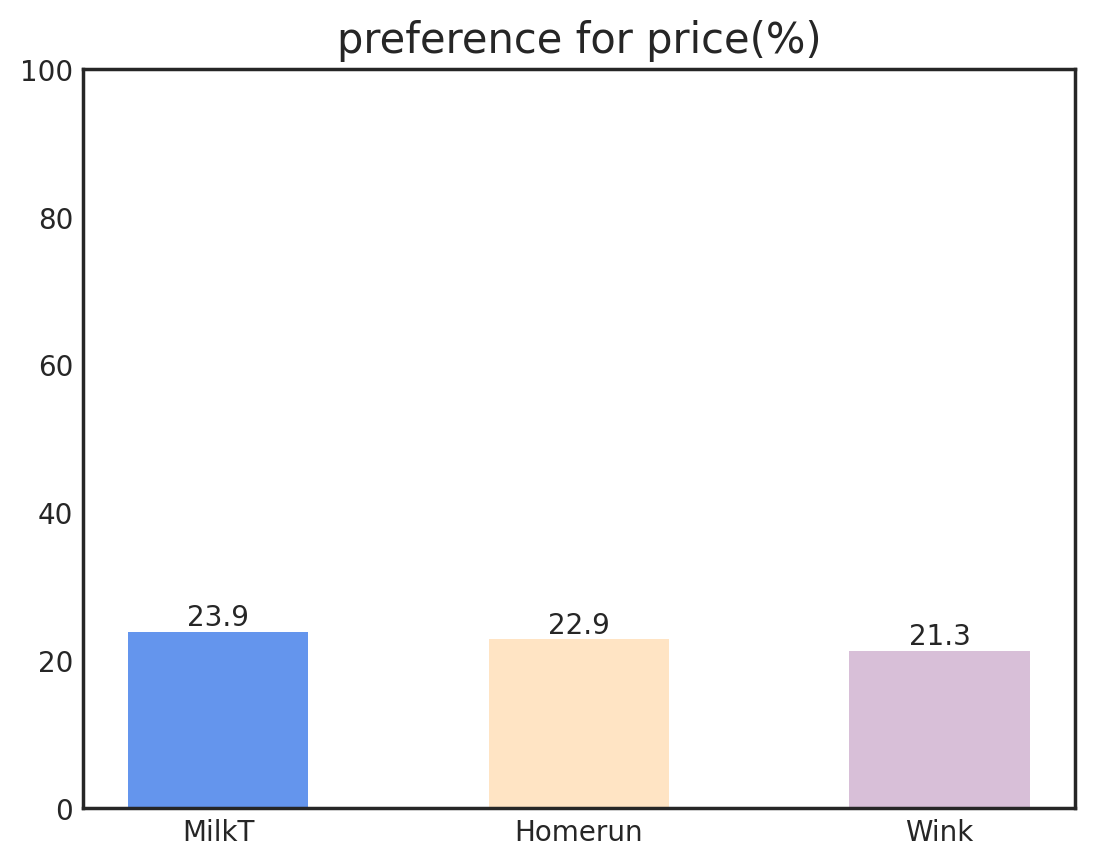

In [34]:
a=[]
for firm in sentiment_firm_price:
    a.append(firm[1]*100)
X=np.arange(len(a))

plt.title("preference for price(%)",fontsize=15)
# plt.xticks()
plt.ylim(0, 100)
plt.xticks([0, 1, 2], labels=['MilkT','Homerun','Wink'])
# plt.xlabel('..')
bar = plt.bar(X,a, color= ['cornflowerblue','bisque','thistle'], alpha = 1.0, width=0.5)

for persent in bar:
    height = persent.get_height()
    plt.text(persent.get_x() + persent.get_width()/2.0, height, '%.1f' % height, ha='center', va='bottom', size = 10)

plt.show()

---
tokenize 를 mecab으로 할 때...

In [35]:
tokens_price=[]
for f, t in tqdm(company_price.items()):
    token_price=mecab.morphs(t)
    tokens_price.append([f,token_price])

100%|██████████| 3/3 [00:05<00:00,  1.85s/it]


In [36]:
sentiment_firm_price=[]
posi_firm_price=[]
nega_firm_price=[]
round_ = 3

start = time.time()

for token_price in tokens_price:
    posi_word = []
    nega_word = []
    firm=token_price[0]
    sentiment=0
    count=0

    posi = 0
    nega = 0

    for t in tqdm((token_price[1])):
        if len(t) > 1:
            # if t in positive_words:
            if any(word in t for word in positive_words): # 사전에 morphs를 써서 세분화 분석을 진행해 볼까... 했는데 정확도가 떨어지기 때문에 X
                posi_words.append(t)
                sentiment+=1
                posi += 1
                count+=1

                # if count < 20:
                #     print('테스트중 : ', t)
                # else : pass
            
            # elif t in negative_words:
            elif any(word in t for word in negative_words):
                nega_word.append(t)
                sentiment -=1
                nega += 1
                count+=1

        else:
            pass
        #     print(t, '테스트...')
        
        
    
    sentiment_firm_price.append([firm,round(sentiment/count,round_)])
    posi_firm_price.append([firm,round(posi/count,round_)])
    nega_firm_price.append([firm,round(nega/count,round_)])
    posi_words = posi_words + posi_word
    nega_words = nega_words + nega_word
    print(f'{firm} 데이터 수 : ', len(token_price[1]))
    print(f'{firm} sentiment filtering 횟수 : ', count)
sentiment_words = posi_words + nega_words
end = time.time()

print('긍정점수 : ', posi_firm_price)
print()
print('부정점수 : ', nega_firm_price)
print()
print('종합점수 : ', sentiment_firm_price)
print()
# print('데이터 수 : ', len(sentiment_words))
print('걸린 시간 : ', round(end - start, round_), '초')

100%|██████████| 447829/447829 [01:03<00:00, 7080.39it/s]


밀크티 데이터 수 :  447829
밀크티 sentiment filtering 횟수 :  19131


100%|██████████| 221502/221502 [00:31<00:00, 7049.26it/s]


홈런 데이터 수 :  221502
홈런 sentiment filtering 횟수 :  9002


100%|██████████| 95261/95261 [00:13<00:00, 7149.67it/s]

윙크 데이터 수 :  95261
윙크 sentiment filtering 횟수 :  4209
긍정점수 :  [['밀크티', 0.507], ['홈런', 0.5], ['윙크', 0.528]]

부정점수 :  [['밀크티', 0.493], ['홈런', 0.5], ['윙크', 0.472]]

종합점수 :  [['밀크티', 0.014], ['홈런', 0.0], ['윙크', 0.055]]

걸린 시간 :  108.031 초
